In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
########################################
### READ TREES AND CREATE DATAFRAMES ###
########################################


# fix random seed for reproducibility
np.random.seed(1986)

#create DataFrames with the values coming from the trees
file_tau = uproot.open('../bc_jpsi_tau_nu_gen_v2.root')
tree_tau = file_tau['tree;1']
tau  = tree_tau.pandas.df(tree_tau.keys())

file_mu = uproot.open('../bc_jpsi_mu_nu_gen_v2.root')
tree_mu = file_mu['tree;2']
mu  = tree_mu.pandas.df(tree_mu.keys())

In [3]:
############################################
### ADD NECESSARY FEATURES TO DATAFRAMES ###
############################################


#add the column target to both dataframes
mu ['target'] = 0
tau['target'] = 1
#add the columns of interesting features (taken from LHCb paper)
mu['m2_miss'] = 0 #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
tau['m2_miss'] = 0
mu['muE_Brf'] = 0 #mu energy in the Bc rest frame
tau['muE_Brf'] = 0
mu['q2'] = 0 #squared 4momentum transfer to lepton sys (p_B - p_mu1 - p_mu2)^2
tau['q2'] = 0
mu['pT_miss'] = 0 #missing transverse momentum (p_B - p_mu1 - p_mu2 - p_mu).Pt
tau['pT_miss'] = 0

bc_vectZ = ROOT.TLorentzVector()
bc_vectT = ROOT.TLorentzVector()
bc_comb = ROOT.TLorentzVector()
jpsi_vect = ROOT.TLorentzVector()
mu_vect = ROOT.TLorentzVector()
mu1_vect = ROOT.TLorentzVector()
mu2_vect = ROOT.TLorentzVector()
reco_vect = ROOT.TLorentzVector()
PV = ROOT.TVector3()
SV = ROOT.TVector3()
mu_mass = 0.10565837 #GeV/c^2
jpsi_mass = 3.096900 #GeV/c^2
bc_mass = 6.2756 #GeV/c^2
c = 2.99e8 #m/s

# in the following, when creating the TLorentzVector of mu, mu1, mu2 we try to account for the reconstruction error
# made by the tracker and the muon system in the value of pT
# we include a gaussian smearing -> we draw a value of pT from a gaussian centered at the value of the MC pT of the
#                                   muon and with sigma 7% of the value of the MC pT (CMS performance)
start = time.time()
i = 0
while i < mu['run'].count(): 
    # set the reconstructed particles 4vectors considering the smearing in the measure of pT due to the 
    # experimental setup (considered to be 7% as a mean between the 1-1.5% at 10GeV and the 6-17% at 1TeV)
    mu_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu_pt'], mu.at[i,'mu_pt']*7/100),0),mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu1_pt'], mu.at[i,'mu1_pt']*7/100),0),mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu2_pt'], mu.at[i,'mu2_pt']*7/100),0),mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)

    # set the PV and SV and calculate primary-secondary vertex distance
    # include smearing of PV reconstruction with a gaussian smearing taken from a CMS paper
    # include smearing of SV reconstruction with a gaussian smearing with sigma double of the PV one
    PV.SetXYZ(np.random.normal(mu.at[i,'pv_x'], 20*1e-6),np.random.normal(mu.at[i,'pv_y'], 20*1e-6),np.random.normal(mu.at[i,'pv_z'], 30*1e-6))
    SV.SetXYZ(np.random.normal(mu.at[i,'sv_x'], 40*1e-6),np.random.normal(mu.at[i,'sv_y'], 40*1e-6),np.random.normal(mu.at[i,'sv_z'], 60*1e-6))
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    
    '''
    # setting the above 4vectors and verteces without the smearing (un-comment it if needed)
    mu_vect.SetPtEtaPhiM(mu.at[i,'mu_pt'],mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(mu.at[i,'mu1_pt'],mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(mu.at[i,'mu2_pt'],mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)
    PV.SetXYZ(mu.at[i,'pv_x'], mu.at[i,'pv_y'], mu.at[i,'pv_z'])
    SV.SetXYZ(mu.at[i,'sv_x'], mu.at[i,'sv_y'], mu.at[i,'sv_z'])
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    '''
    
    reco_vect = mu_vect + mu1_vect + mu2_vect
    
    # reconstruct the pT of the Bc and set the 4vector
    bc_pZreco = (bc_mass / reco_vect.Mag()) * reco_vect.Pz()
    bc_pXreco = bc_pZreco*(SV.X()-PV.X())/(SV.Z() - PV.Z())
    bc_pYreco = bc_pZreco*(SV.Y()-PV.Y())/(PV.Z()-SV.Z())
    bc_Preco = bc_pZreco * dist_PSV / ((SV.Z() - PV.Z())*1e-2)
    bc_vectZ.SetPtEtaPhiM(np.sqrt(bc_pXreco**2+bc_pYreco**2),mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],bc_mass)
    
    # test using the reconstruction of pT instead of pZ
    bc_pTreco = bc_mass * reco_vect.Pt() / reco_vect.Mag() 
    bc_vectT.SetPtEtaPhiM(bc_pTreco,mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],bc_mass)
    
    # combine the two reconstruction methods 
    bc_comb.SetPtEtaPhiM((bc_pTreco+np.sqrt(bc_pXreco**2+bc_pYreco**2))/2,mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],bc_mass)   
    
    m2_vect = bc_vectZ - mu1_vect - mu2_vect - mu_vect
    q2_vect = bc_vectZ - mu1_vect - mu2_vect
    
    mu.at[i,'m2_miss'] = m2_vect.Mag2()
    mu.at[i,'q2'] = q2_vect.Mag2()
    mu.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vectZ.Rapidity())
    mu.at[i,'pT_miss'] = m2_vect.Pt()
    
    # decay length and time
    mu.at[i,'bc_DL'] = dist_PSV
    mu.at[i,'bcZ_CT'] = dist_PSV / (bc_vectZ.Gamma()*bc_vectZ.Beta())   
    mu.at[i,'bcT_CT'] = dist_PSV / (bc_vectT.Gamma()*bc_vectT.Beta()) 
    mu.at[i,'bcComb_CT'] = dist_PSV / (bc_comb.Gamma()*bc_comb.Beta())  
    # reconstructed Bc mass
    mu.at[i,'bcZ_mass'] = bc_vectZ.Mag()
    mu.at[i,'bcT_mass'] = bc_vectT.Mag()
    mu.at[i,'bcComb_mass'] = bc_vectT.Mag()
    # reconstructed Bc pT
    mu.at[i,'bcZ_pt'] = bc_vectZ.Pt()
    mu.at[i,'bcT_pt'] = bc_vectT.Pt()
    mu.at[i,'bcComb_pt'] = bc_vectT.Pt()
    
    # we look for the best roconstruction of the jpsi 
    muons = [mu_vect,mu1_vect,mu2_vect]
    muons_charge = [mu.at[i,'mu_charge'],mu.at[i,'mu1_charge'],mu.at[i,'mu2_charge']]
    pair_vect = ROOT.TLorentzVector()
    if muons_charge[0] != muons_charge[1]:
        pair1_vect = muons[0] + muons[1]
        pair2_vect = muons[1] + muons[2]
    else:
        pair1_vect = muons[0] + muons[2]
        pair2_vect = muons[1] + muons[2]
     
    if (abs(pair1_vect.Mag() - jpsi_mass)) < abs((pair2_vect.Mag() - jpsi_mass)):
        mu.at[i,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
    else:
        mu.at[i,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
    
    i += 1

                               
i = 0
while i < tau['run'].count():
    # set the reconstructed particles 4vectors considering the smearing in the measure of pT due to the 
    # experimental setup (considered to be 7% as a mean between the 1-1.5% at 10GeV and the 6-17% at 1TeV)
    mu_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu_pt'], tau.at[i,'mu_pt']*7/100),0),tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu1_pt'], tau.at[i,'mu1_pt']*7/100),0),tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu2_pt'], tau.at[i,'mu2_pt']*7/100),0),tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)

    # set the PV and SV and calculate primary-secondary vertex distance
    # include smearing of PV reconstruction with a gaussian smearing taken from a CMS paper
    # include smearing of SV reconstruction with a gaussian smearing with sigma double of the PV one
    PV.SetXYZ(np.random.normal(tau.at[i,'pv_x'], 20*1e-6),np.random.normal(tau.at[i,'pv_y'], 20*1e-6),np.random.normal(tau.at[i,'pv_z'], 30*1e-6))
    SV.SetXYZ(np.random.normal(tau.at[i,'sv_x'], 40*1e-6),np.random.normal(tau.at[i,'sv_y'], 40*1e-6),np.random.normal(tau.at[i,'sv_z'], 60*1e-6))
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    
    '''
    # setting the above 4vectors and verteces without the smearing (un-comment it if needed)
    mu_vect.SetPtEtaPhiM(tau.at[i,'mu_pt'],tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(tau.at[i,'mu1_pt'],tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(tau.at[i,'mu2_pt'],tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)
    PV.SetXYZ(tau.at[i,'pv_x'], tau.at[i,'pv_y'], tau.at[i,'pv_z'])
    SV.SetXYZ(tau.at[i,'sv_x'], tau.at[i,'sv_y'], tau.at[i,'sv_z'])
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    '''
    
    reco_vect = mu_vect + mu1_vect + mu2_vect
    
    # reconstruct the pT of the Bc and set the 4vector
    bc_pZreco = (bc_mass / reco_vect.Mag()) * reco_vect.Pz()
    bc_pXreco = bc_pZreco*(SV.X()-PV.X())/(SV.Z() - PV.Z())
    bc_pYreco = bc_pZreco*(SV.Y()-PV.Y())/(PV.Z()-SV.Z())
    bc_Preco = bc_pZreco * dist_PSV / ((SV.Z() - PV.Z())*1e-2)
    bc_vectZ.SetPtEtaPhiM(np.sqrt(bc_pXreco**2+bc_pYreco**2),tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],bc_mass)
    
    # using the reconstruction of pT instead of pZ
    bc_pTreco = (bc_mass / reco_vect.Mag()) * reco_vect.Pt()
    bc_vectT.SetPtEtaPhiM(bc_pTreco,tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],bc_mass)
    
    # combine the two reconstruction methods 
    bc_comb.SetPtEtaPhiM((bc_pTreco+np.sqrt(bc_pXreco**2+bc_pYreco**2))/2,tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],bc_mass) 
    
    m2_vect = bc_vectZ - mu1_vect - mu2_vect - mu_vect
    q2_vect = bc_vectZ - mu1_vect - mu2_vect
    
    tau.at[i,'m2_miss'] = m2_vect.Mag2()
    tau.at[i,'q2'] = q2_vect.Mag2()
    tau.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vectZ.Rapidity())
    tau.at[i,'pT_miss'] = m2_vect.Pt()
    
    # decay length and decay time(c*tau)
    tau.at[i,'bc_DL'] = dist_PSV
    tau.at[i,'bcZ_CT'] = dist_PSV / (bc_vectZ.Gamma()*bc_vectZ.Beta())
    tau.at[i,'bcT_CT'] = dist_PSV / (bc_vectT.Gamma()*bc_vectT.Beta())  
    tau.at[i,'bcComb_CT'] = dist_PSV / (bc_comb.Gamma()*bc_comb.Beta())  
    # reconstructed Bc mass
    tau.at[i,'bcZ_mass'] = bc_vectZ.Mag()
    tau.at[i,'bcT_mass'] = bc_vectT.Mag()
    tau.at[i,'bcComb_mass'] = bc_vectT.Mag()
    # reconstructed Bc pT
    tau.at[i,'bcZ_pt'] = bc_vectZ.Pt()
    tau.at[i,'bcT_pt'] = bc_vectT.Pt()
    tau.at[i,'bcComb_pt'] = bc_vectT.Pt()
                          
    # we look for the best roconstruction of the jpsi 
    muons = [mu_vect,mu1_vect,mu2_vect]
    muons_charge = [mu.at[i,'mu_charge'],mu.at[i,'mu1_charge'],mu.at[i,'mu2_charge']]
    pair_vect = ROOT.TLorentzVector()
    if muons_charge[0] != muons_charge[1]:
        pair1_vect = muons[0] + muons[1]
        pair2_vect = muons[1] + muons[2]
    else:
        pair1_vect = muons[0] + muons[2]
        pair2_vect = muons[1] + muons[2]
     
    if (abs(pair1_vect.Mag() - jpsi_mass)) < (abs(pair2_vect.Mag() - jpsi_mass)):
        tau.at[i,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
    else:
        tau.at[i,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
    
    i += 1
    
end = time.time()
print 'Running time to add the new vars to the df = %.1f'%(end - start)

Running time to add the new vars to the df = 1571.3


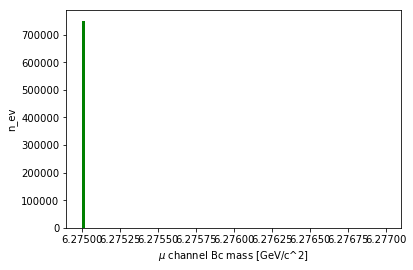

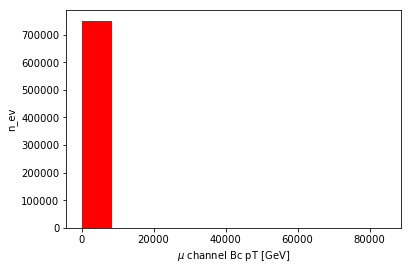

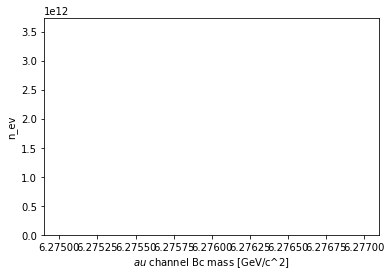

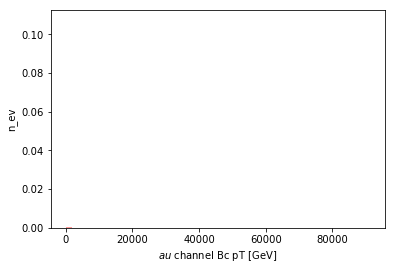

In [4]:
###############################################################################
### COMPARE THE DISTRIBUTIONS OF THE THREE DIFFERENT RECONSTRUCTION METHODS ###
###############################################################################


plt.hist(mu['bc_mass'], bins=100, color='g', label='MC')
plt.hist(mu['bcZ_mass'], bins=100, color='r', label='pZ reco')
plt.hist(mu['bcT_mass'], bins=100, color='b', label='pT reco')
plt.hist(mu['bcComb_mass'], bins=100, color='y', label='comb reco')
plt.xlabel('$\mu$ channel Bc mass [GeV/c^2]')
plt.ylabel('n_ev')
plt.show()

plt.hist(mu['bc_pt'], color='g', label='MC')
plt.hist(mu['bcZ_pt'], color='r', label= 'pZ reco')
plt.hist(mu['bcT_pt'], color='b', label='pT reco')
plt.hist(mu['bcComb_pt'], color='y', label='comb reco')
plt.xlabel('$\mu$ channel Bc pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(tau['bc_mass'], kde=False, color='g', norm_hist=True, label='MC')
sb.distplot(tau['bcZ_mass'], kde=False, color='r', norm_hist=True, label= 'pZ reco')
sb.distplot(tau['bcT_mass'], kde=False, color='b', norm_hist=True, label='pT reco')
sb.distplot(tau['bcComb_mass'], kde=False, color='y', norm_hist=True, label='comb reco')
plt.xlabel('$\tau$ channel Bc mass [GeV/c^2]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(tau['bc_pt'], kde=False, color='g', norm_hist=True, label='MC')
sb.distplot(tau['bcZ_pt'], kde=False, color='r', norm_hist=True, label= 'pZ reco')
sb.distplot(tau['bcT_pt'], kde=False, color='b', norm_hist=True, label='pT reco')
sb.distplot(tau['bcComb_pt'], kde=False, color='y', norm_hist=True, label='comb reco')
plt.xlabel('$\tau$ channel Bc pT [GeV]')
plt.ylabel('n_ev')
plt.show()

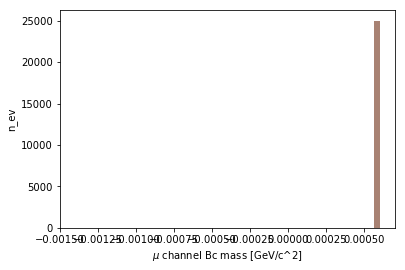

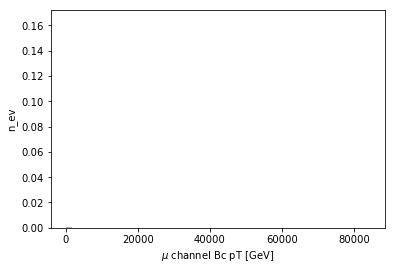

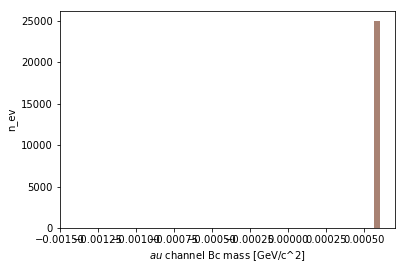

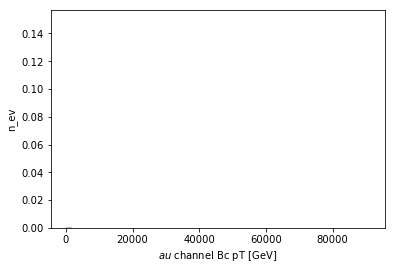

In [20]:
####################################################################################
### COMPARE THE DIFF DISTRIBUTIONS OF THE THREE DIFFERENT RECONSTRUCTION METHODS ###
####################################################################################


sb.distplot(mu['bcZ_mass']-mu['bc_mass'], kde=False, color='r', norm_hist=True, label='pZ reco')
sb.distplot(mu['bcT_mass']-mu['bc_mass'], kde=False, color='b', norm_hist=True, label='pT reco')
sb.distplot(mu['bcComb_mass']-mu['bc_mass'], kde=False, color='y', norm_hist=True, label='comb reco')
plt.xlabel('$\mu$ channel Bc mass [GeV/c^2]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu['bcZ_pt']-mu['bc_pt'], kde=False, color='r', norm_hist=True, label= 'pZ reco')
sb.distplot(mu['bcT_pt']-mu['bc_pt'], kde=False, color='b', norm_hist=True, label='pT reco')
sb.distplot(mu['bcComb_pt']-mu['bc_pt'], kde=False, color='y', norm_hist=True, label='comb reco')
plt.xlabel('$\mu$ channel Bc pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(tau['bcZ_mass']-tau['bc_mass'], kde=False, color='r', norm_hist=True, label= 'pZ reco')
sb.distplot(tau['bcT_mass']-tau['bc_mass'], kde=False, color='b', norm_hist=True, label='pT reco')
sb.distplot(tau['bcComb_mass']-tau['bc_mass'], kde=False, color='y', norm_hist=True, label='comb reco')
plt.xlabel('$\tau$ channel Bc mass [GeV/c^2]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(tau['bcZ_pt']-tau['bc_pt'], kde=False, color='r', norm_hist=True, label= 'pZ reco')
sb.distplot(tau['bcT_pt']-tau['bc_pt'], kde=False, color='b', norm_hist=True, label='pT reco')
sb.distplot(tau['bcComb_pt']-tau['bc_pt'], kde=False, color='y', norm_hist=True, label='comb reco')
plt.xlabel('$\tau$ channel Bc pT [GeV]')
plt.ylabel('n_ev')
plt.show()

In [36]:
###############################################################################
### COMPARE THE LIFETIME RECO OF THE THREE DIFFERENT RECONSTRUCTION METHODS ###
###############################################################################

totT = tau['bcT_CT'].sum() + mu['bcT_CT'].sum()
totComb = tau['bcComb_CT'].sum() + mu['bcComb_CT'].sum()
totZ = tau['bcZ_CT'].sum() + mu['bcZ_CT'].sum()


print 'pZ reconstruction lifetime = %.4f'%((totZ/c)*1e12/(tau['bcZ_CT'].count()+mu['bcZ_CT'].count()))
print 'pT reconstruction lifetime = %.4f'%((totT/c)*1e12/(tau['bcT_CT'].count()+mu['bcT_CT'].count()))
print 'comb reconstruction lifetime = %.4f'%((totComb/c)*1e12/(tau['bcComb_CT'].count()+mu['bcComb_CT'].count()))

pZ reconstruction lifetime = 1.3382
pT reconstruction lifetime = 0.4471
comb reconstruction lifetime = 0.4433


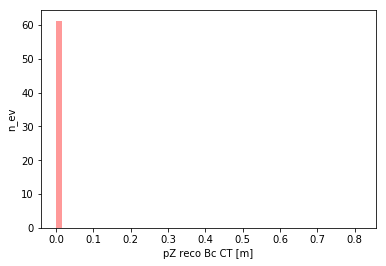

In [48]:
###########################################################################
### FIT THE LIFETIME RECO OF THE THREE DIFFERENT RECONSTRUCTION METHODS ###
###########################################################################


from scipy import optimize
from pylab import exp
def Exp(x,a,norm):
    return norm * exp(-a*x)


sb.distplot(tau['bcZ_CT'], kde=False, color='r', norm_hist=True, label= 'pZ reco')
plt.xlabel('pZ reco Bc CT [m]')
plt.ylabel('n_ev')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



best fitted parameters (exp,norm) :  (array([7830.18962445, 5852.11333054]), array([[330.14619727,  64.64530567],
       [ 64.64530567,  53.77020122]])) 

Traceback (most recent call last):
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/inspect.py", line 1051, in getinnerframes
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/inspect.py", line 1011, in getframeinfo
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/inspect.py", line 453, in getsourcefile
  File "/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/inspect.py", line 482, i

IndexError: string index out of range

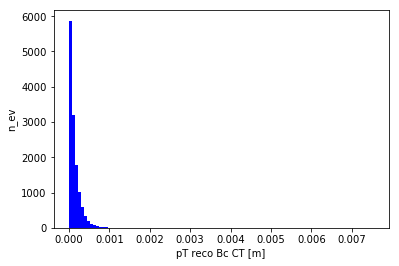

In [49]:
bins = 100
binned_data,bins_edges,patches = plt.hist(mu['bcT_CT'], bins=bins, density=True, color='b', label='pT reco')
plt.xlabel('pT reco Bc CT [m]')
plt.ylabel('n_ev')
x_eval = np.delete(bins_edges,99)
popt = optimize.curve_fit(Exp,x_eval,binned_data)
print 'best fitted parameters (exp,norm) : ', popt,'\n'
plt.plot(bins_edges,Exp(bins_edges,popt[0],popt[1]),'r',label='exp fit')
plt.legend()
plt.show()

print popt[0]/c

best fitted parameters (Norm,exp) :  (array([-791.39135396]), array([[1.02366591e+08]])) 



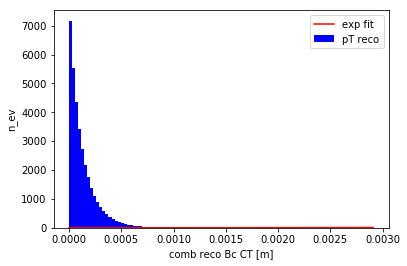

[-2.64679383e-06]


In [46]:
binned_data,bins_edges,patches = plt.hist(mu['bcComb_CT'], bins=bins, density=True, color='b', label='pT reco')
plt.xlabel('comb reco Bc CT [m]')
plt.ylabel('n_ev')
x_eval = np.delete(bins_edges,99)
popt = optimize.curve_fit(Exp,x_eval,binned_data)
print 'best fitted parameters (Norm,exp) : ', popt,'\n'
plt.plot(bins_edges,Exp(bins_edges,popt[0]),'r',label='exp fit')
plt.legend()
plt.show()

print popt[0]/c